<a href="https://colab.research.google.com/github/Soob00/20251R0136COSE47101/blob/dataset2_employed/dataset2/notebooks/dataset2_SMI_SED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 실제 분석 및 과정

# 통계적 차이 검정

- 숫자형 - ANOVA
- 범주형 - 카이제곱

# SMI/SED/진단없음 분석 및 SHAP

## 랜덤포레스트, XGBOOST

### 고려한 점

- (0=해당없음, 1=SMI, 2=SED)

### 앞으로 생각해볼 지점

아마도 feature들로 인해 target(SMI,SED,해당없음)으로 인과관계를 정리해볼 수는 있겠으나 이는 논문 등을 참고해서 진행해야할 것 같음.

현재 분석 결과만으로는 인과관계보다는 상관관계에 가깝다고 보아야함.

### 랜덤포레스트 결과

- 전체변수 포함: 정확도 0.76
    - 정확도는 높으나, 너무 이론적으로 당연한 결고ㅘ

```markdown
### 클래스 0
age, schizoflg, mh1, depressflg, stateip 순.

연령, 조현병 진단 여부, 주진단코드의 여부, 우울증 여부,state 정보가 정신질환에 큰 영향을 줌.

### 클래스 1 (중증 정신질환)

age, educ, detnlf_2, stateip, marstat_4

연령(낮을수록), 교육수준(낮을수록), 경제활동(없을수록), 지역적 차이, 결혼상태(불안정)

### 클래스 2 (심한 정서질환)
mh1, schizoflg, stateip, age, depresflg

SED에 해당하는 특정 진단 코드, 조현병 진단 여부, 거주지, 나이(청소년일수록), 우울증 진단 여부
```

- 진단변수 미포함 : 정확도 0.68
    - 정확도는 조금 낮지만, 더 유의미한 설명이 가능함.
    - 코드 결과는 노션 참고
        

### XGBOOST 결과

- 전체 변수 포함 - 정확도 : 0.85
    - 정확도는 좋지만, 정신질환이 있을 때 더 심한 질환/ 증상을 가지게 된다는 것은 너무 이론적으로 당연한 이야기
- **진단 변수 미포함 - 정확도 : 0.82**
- 코드 결과는 노션참고

# 로지스틱 회귀 분석

SHAP에서 높게 나온 것들 위주로 변수를 선택하고, 그것으로 로지스틱 회귀분석을 진행함.

```markdown

클래스 0, 즉 정신질환이 없는 사람들과 비교했을 때 차이점을 확인함.

### 클래스 1 (SMI-중증 정신질환)
stateip, nummhs, employ, educ, detnlf_2, traustreflg, division_3, race_3 순서로 높게 나타남.

따라서 거주지역, 서비스의 양, 고용 혹은 교육, 인종이 크게 의미를 가진다는 것을 볼 수 있음

SHAP으로 분석한 것과 다르게 연령이 큰 영향을 미치지 않음.

### 클래스 2 (SED-심각한 정서질환)
age, nummhs, employ, educ, detnlf_2, division_8, race_3, stateip, traustreflg 기준으로 높게 나타남

따라서 청소년, 교육ㅇ 부족, 경제활동을 하지 않음, 특정 지역과 연관되어 있을 때 의미를 가짐.

연령이 유의미한 결과를 미침.
회귀분석 결과 또한 아래 결과 혹은 노션 참고

# **STEP1. 통계적 차이 검정**

In [7]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/단순결측치 행 제거.csv'
df = pd.read_csv(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


전체적으로 단순 결측값 데이터셋, 결측값 모두 제거한 데이터셋 두개를 돌렸을 때 SMISED와 각 FEATURE들의 관계성은 비슷하게 나타남.

In [8]:
# 단순결측치 행 제거로 돌린 통계적 차이 검정

numeric_ = ["AGE", "EDUC", "NUMMHS"]
target = "SMISED"

# 수치형 - ANOVA + Tukey HSD
# t test 보다 anova가 적합함
for variable in numeric_:
    print(f"ANOVA for {variable}")
    model = ols(f"{variable} ~ C({target})", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table)

    # Tukey HSD - 그룹 사이의 차이를 발견하기
    tukey = pairwise_tukeyhsd(df[variable], df[target])
    print("Tukey HSD:")
    print(tukey)

# 범주형 변수 - 지역변수 및 질병 관려 전부 포험
categorical = [
    "ETHNIC", "RACE", "GENDER", "SPHSERVICE", "CMPSERVICE", "OPISERVICE",
    "RTCSERVICE", "IJSSERVICE", "SUB", "MARSTAT", "SMISED", "EMPLOY",
    "DETNLF", "VETERAN", "LIVARAG", "DIVISION", "REGION", "STATEFIP"
]

# chi-square
for var in categorical:
    print(f"Chi-square test for {var}")
    contingency_table = pd.crosstab(df[var], df[target])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"Chi2: {chi2:.3f}, p-value: {p:.4f}")
    print(contingency_table)


ANOVA for AGE
                  sum_sq         df             F  PR(>F)
C(SMISED)  213562.163671        2.0  1.939641e+06     0.0
Residual   292744.796399  5317607.0           NaN     NaN
Tukey HSD:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     1      2  -0.5389   0.0 -0.5395 -0.5382   True
     1      3  -0.1577   0.0 -0.1583 -0.1572   True
     2      3   0.3811   0.0  0.3804  0.3819   True
---------------------------------------------------
ANOVA for EDUC
                 sum_sq         df             F  PR(>F)
C(SMISED)  4.698579e+05        2.0  10263.551572     0.0
Residual   1.217181e+08  5317607.0           NaN     NaN
Tukey HSD:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     1      2  -0.7943   0.0 -0.8074 -0.7812   True
     1      3  -0.1142   0.0 -0.

In [9]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

numeric_ = ["AGE", "EDUC", "NUMMHS"]
categorical = [
    "ETHNIC", "RACE", "GENDER", "SPHSERVICE", "CMPSERVICE", "OPISERVICE",
    "RTCSERVICE", "IJSSERVICE", "SUB", "MARSTAT", "EMPLOY",
    "DETNLF", "VETERAN", "LIVARAG", "DIVISION", "REGION", "STATEFIP"
]
target = "SMISED"

anova_results = []
tukey_results = []
chi2_results = []

for variable in numeric_:
    model = ols(f"{variable} ~ C({target})", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    F = anova_table.loc[f"C({target})", "F"]
    pval = anova_table.loc[f"C({target})", "PR(>F)"]
    anova_results.append({
        "Variable": variable,
        "F-stat": F,
        "p-value": pval
    })

    tukey = pairwise_tukeyhsd(df[variable], df[target])
    tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
    tukey_df["Variable"] = variable
    tukey_results.append(tukey_df)

for var in categorical:
    contingency_table = pd.crosstab(df[var], df[target])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    chi2_results.append({
        "Variable": var,
        "Chi2": chi2,
        "p-value": p,
        "DoF": dof
    })


anova_df = pd.DataFrame(anova_results)
tukey_df = pd.concat(tukey_results, ignore_index=True)
chi2_df = pd.DataFrame(chi2_results)


print("\n[ANOVA Table]")
print(anova_df)

print("\n[Tukey HSD]")
print(tukey_df)

print("\n[Chi-square Table]")
print(chi2_df)




[ANOVA Table]
  Variable        F-stat  p-value
0      AGE  1.939641e+06      0.0
1     EDUC  1.026355e+04      0.0
2   NUMMHS  3.130389e+04      0.0

[Tukey HSD]
   group1  group2  meandiff  p-adj   lower   upper  reject Variable
0       1       2   -0.5389    0.0 -0.5395 -0.5382    True      AGE
1       1       3   -0.1577    0.0 -0.1583 -0.1572    True      AGE
2       2       3    0.3811    0.0  0.3804  0.3819    True      AGE
3       1       2   -0.7943    0.0 -0.8074 -0.7812    True     EDUC
4       1       3   -0.1142    0.0 -0.1257 -0.1027    True     EDUC
5       2       3    0.6801    0.0  0.6653  0.6949    True     EDUC
6       1       2   -0.0757    0.0 -0.0779 -0.0735    True   NUMMHS
7       1       3   -0.2081    0.0 -0.2100 -0.2061    True   NUMMHS
8       2       3   -0.1324    0.0 -0.1349 -0.1299    True   NUMMHS

[Chi-square Table]
      Variable          Chi2        p-value  DoF
0       ETHNIC  6.522410e+04   0.000000e+00    6
1         RACE  9.530195e+04   0.00000

**AGE**	1 < 2 < 3	SMISED 높을수록 나이 증가

**EDUC** 	3번 그룹(중증)의 교육 수준 매우 낮음

**NUMMHS**	서비스 많이 이용한 그룹들이 있어보이나, 그렇게 연관성이 커보이지는 않음

**ETHNIC** 인종/민족으로 차이가 있어보임

**RACE** 인종

**GENDER** 남/녀 비율 다름

**SPHSERVICE** SMISED가 높을수록 이용 증가

**CMPSERVICE**	일부 그룹만 이용

**OPISERVICE**	외래 서비스 차이 큼	접근성 or 서비스 패턴 차이

**RTCSERVICE** 조금 약한데, 그래도 차이 있어보임

**SUB (Substance Use)**	정신질환과 약물 사용 연관성 있음

**MARSTAT (결혼상태)** 미혼 or 이혼 그룹에서 많음

**EMPLOY**	무직 비율이 높음

          SMISED가 높을수록 고용률 낮음

**DETNLF**	경제활동 인구나 노동 참여 관련

**VETERAN**	 군복무 경험 여부

**LIVARAG** 동거 여부

**DIVISION** 지역 간 분포 다름
          
          얘 또한 지역별 차이로, 정책이나 지원을 반영했거나
          우리의 전처리 과정에서의 차이일 수 있을 것

**REGION**	북동/남부 등 차이 존재

          이것 또한 결측치 많은 지역들이 삭제되어 데이터 전체에 영향을 주었을 기능성이 있어 보임

**STATEFIP**	주별 분포 다름	데이터 구조상 영향 큼

          주별로 결측치가 많은 주가 삭제되어서 그런지, 데이터 자체의 차이가 큰 것 같음.
          + 변수 개수 많아 원핫 주의


In [10]:
print(df.columns.tolist())


['YEAR', 'AGE', 'EDUC', 'ETHNIC', 'RACE', 'GENDER', 'SPHSERVICE', 'CMPSERVICE', 'OPISERVICE', 'RTCSERVICE', 'IJSSERVICE', 'MH1', 'MH2', 'MH3', 'SUB', 'MARSTAT', 'SMISED', 'SAP', 'EMPLOY', 'DETNLF', 'VETERAN', 'LIVARAG', 'NUMMHS', 'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG', 'STATEFIP', 'DIVISION', 'REGION', 'CASEID']


In [11]:
from google.colab import drive
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
drive.mount('/content/drive')

# 1. 데이터 불러오기
file_path = '/content/drive/MyDrive/결측치가 포함된 모든 행 제거.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
print(df.columns.tolist())


['YEAR', 'AGE', 'EDUC', 'ETHNIC', 'RACE', 'GENDER', 'SPHSERVICE', 'CMPSERVICE', 'OPISERVICE', 'RTCSERVICE', 'IJSSERVICE', 'MH1', 'MH2', 'MH3', 'SUB', 'MARSTAT', 'SMISED', 'SAP', 'EMPLOY', 'DETNLF', 'VETERAN', 'LIVARAG', 'NUMMHS', 'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG', 'STATEFIP', 'DIVISION', 'REGION', 'CASEID']


In [13]:
# 모든 결측치 제거한 데이터셋 활용 분석

numeric_ = ["AGE", "EDUC", "NUMMHS"]
target = "SMISED"

# 수치형 - ANOVA + Tukey HSD
# t test 보다 anova가 적합함
for variable in numeric_:
    print(f"ANOVA for {variable}")
    model = ols(f"{variable} ~ C({target})", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table)

    # Tukey HSD - 그룹 사이의 차이를 발견하기
    tukey = pairwise_tukeyhsd(df[variable], df[target])
    print("Tukey HSD:")
    print(tukey)

# 범주형 변수 - 지역변수 및 질병 관려 전부 포험
categorical = [
    "ETHNIC", "RACE", "GENDER", "SPHSERVICE", "CMPSERVICE", "OPISERVICE",
    "RTCSERVICE", "IJSSERVICE", "SUB", "MARSTAT", "SMISED", "EMPLOY",
    "DETNLF", "VETERAN", "LIVARAG", "DIVISION", "REGION", "STATEFIP"
]

# chi-square
for var in categorical:
    print(f"Chi-square test for {var}")
    contingency_table = pd.crosstab(df[var], df[target])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"Chi2: {chi2:.3f}, p-value: {p:.4f}")
    print(contingency_table)



ANOVA for AGE
                 sum_sq         df             F  PR(>F)
C(SMISED)   7627.331877        2.0  77138.201968     0.0
Residual   56745.448452  1147778.0           NaN     NaN
Tukey HSD:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     1      2  -0.4482   0.0  -0.451 -0.4453   True
     1      3  -0.0824   0.0 -0.0835 -0.0812   True
     2      3   0.3658   0.0  0.3628  0.3687   True
---------------------------------------------------
ANOVA for EDUC
                 sum_sq         df             F  PR(>F)
C(SMISED)   2947.253697        2.0  28502.441533     0.0
Residual   59342.161098  1147778.0           NaN     NaN
Tukey HSD:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     1      2  -0.2702   0.0 -0.2731 -0.2673   True
     1      3  -0.0593   0.0 -0.060

# **STEP2~3. SMI/SED/진단 없음 트리기반 분석 및 SHAP**

 (0=해당없음, 1=SMI, 2=SED)

In [14]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

file_path = '/content/drive/MyDrive/원핫인코딩_결측치가 포함된 모든 행 제거.csv'
df = pd.read_csv(file_path)

In [15]:

pd.set_option('display.max_columns', None)
df.head(10)

,YEAR,AGE,EDUC,GENDER,SPHSERVICE,CMPSERVICE,OPISERVICE,RTCSERVICE,IJSSERVICE,MH1,MH2,MH3,SAP,EMPLOY,VETERAN,NUMMHS,TRAUSTREFLG,ANXIETYFLG,ADHDFLG,CONDUCTFLG,DELIRDEMFLG,BIPOLARFLG,DEPRESSFLG,ODDFLG,PDDFLG,PERSONFLG,SCHIZOFLG,ALCSUBFLG,OTHERDISFLG,STATEFIP,CASEID,RACE_2,RACE_3,RACE_4,RACE_5,RACE_6,ETHNIC_2,ETHNIC_3,ETHNIC_4,REGION_1,REGION_2,REGION_3,REGION_4,SUB_1,SUB_2,SUB_3,SUB_4,SUB_5,SUB_6,SUB_7,SUB_8,SUB_9,SUB_10,SUB_11,SUB_12,SUB_13,MARSTAT_2,MARSTAT_3,MARSTAT_4,SMISED_2,SMISED_3,DETNLF_2,DETNLF_3,DETNLF_4,DETNLF_5,DETNLF_NotApplicable,LIVARAG_2,LIVARAG_3,DIVISION_1,DIVISION_2,DIVISION_3,DIVISION_4,DIVISION_5,DIVISION_6,DIVISION_7,DIVISION_8,DIVISION_9
0,2022,0.461538,0.50,1,0,1,0,0,0,7,11,-99,1,0.25,0,2,0,0,0,0,0,0,1,0,0,0,1,0,0,1,20220000002,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False
1,2022,1.000000,0.75,0,1,1,0,0,0,11,-99,-99,2,0.00,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,20220000004,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False
2,2022,0.615385,1.00,0,0,1,1,0,0,7,1,2,1,0.00,0,3,1,1,0,0,0,0,1,0,0,0,0,0,0,1,20220000013,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False
3,2022,0.615385,1.00,0,0,1,1,0,0,7,-99,-99,2,1.00,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,20220000025,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False
4,2022,0.846154,0.50,0,0,1,0,0,0,6,-99,-99,1,0.00,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,20220000029,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False
5,2022,0.538462,0.50,1,0,1,0,0,0,6,13,-99,1,0.00,0,2,0,0,0,0,0,1,0,0,0,0,0,0,1,1,20220000031,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False
6,2022,0.461538,1.00,0,0,1,0,0,0,2,-99,-99,2,1.00,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,20220000033,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False
7,2022,0.692308,0.75,0,0,1,0,0,0,7,-99,-99,2,0.25,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,20220000034,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False
8,2022,0.384615,0.75,1,0,1,0,0,0,6,-99,-99,2,1.00,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,20220000038,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False
9,2022,0.846154,0.75,0,0,1,1,0,0,11,-99,-99,2,0.25,0,1,0,0,0,0,0,0,0

In [16]:
print(df.columns.tolist())

['YEAR', 'AGE', 'EDUC', 'GENDER', 'SPHSERVICE', 'CMPSERVICE', 'OPISERVICE', 'RTCSERVICE', 'IJSSERVICE', 'MH1', 'MH2', 'MH3', 'SAP', 'EMPLOY', 'VETERAN', 'NUMMHS', 'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG', 'STATEFIP', 'CASEID', 'RACE_2', 'RACE_3', 'RACE_4', 'RACE_5', 'RACE_6', 'ETHNIC_2', 'ETHNIC_3', 'ETHNIC_4', 'REGION_1', 'REGION_2', 'REGION_3', 'REGION_4', 'SUB_1', 'SUB_2', 'SUB_3', 'SUB_4', 'SUB_5', 'SUB_6', 'SUB_7', 'SUB_8', 'SUB_9', 'SUB_10', 'SUB_11', 'SUB_12', 'SUB_13', 'MARSTAT_2', 'MARSTAT_3', 'MARSTAT_4', 'SMISED_2', 'SMISED_3', 'DETNLF_2', 'DETNLF_3', 'DETNLF_4', 'DETNLF_5', 'DETNLF_NotApplicable', 'LIVARAG_2', 'LIVARAG_3', 'DIVISION_1', 'DIVISION_2', 'DIVISION_3', 'DIVISION_4', 'DIVISION_5', 'DIVISION_6', 'DIVISION_7', 'DIVISION_8', 'DIVISION_9']


### **Random Forest 기반, 모든 변수 포함**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 0.7623


PermutationExplainer explainer: 301it [01:33,  3.07it/s]


None


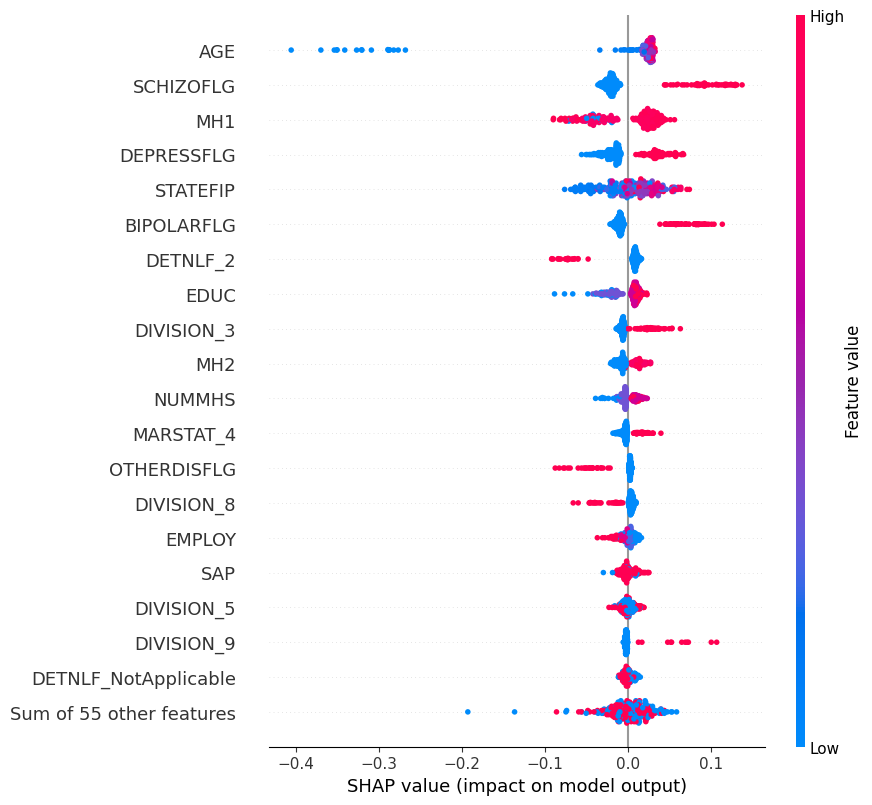

SMI


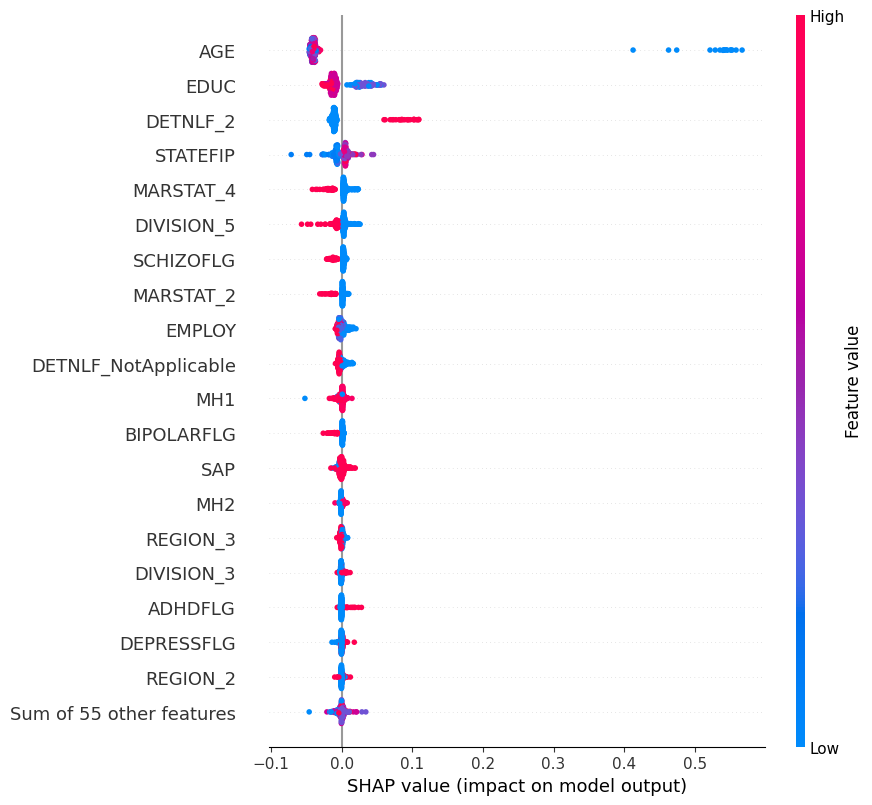

SED


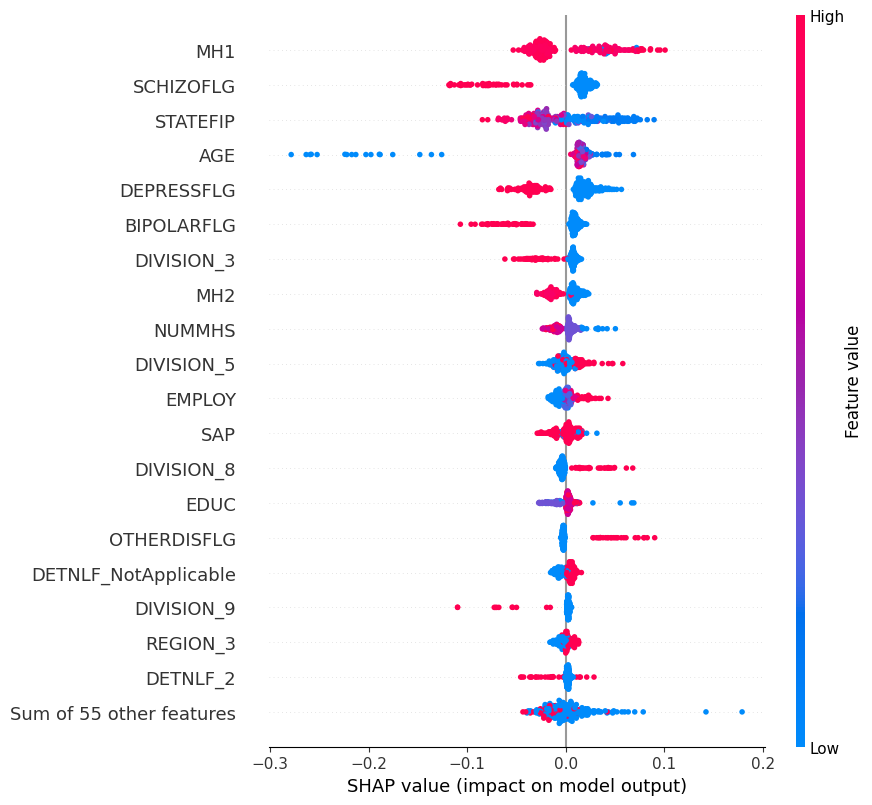

In [17]:
from google.colab import drive
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/원핫인코딩_결측치가 포함된 모든 행 제거.csv'
df = pd.read_csv(file_path)

# SMISED 타겟 컬럼 생성 (0=해당없음, 1=SMI, 2=SED)
df["SMISED"] = df[["SMISED_2", "SMISED_3"]].apply(
    lambda row: 1 if row["SMISED_2"] == 1 else (2 if row["SMISED_3"] == 1 else 0), axis=1)
y = df["SMISED"]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"], errors="ignore")
X = X.astype(float)

# 랜덤포레스트
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
model.fit(X, y)

# 예측 및 정확도
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.4f}")

# SHAP
X_sample = X.sample(n=300, random_state=42)
def predict_proba_fn(X_input):
    return model.predict_proba(X_input)
explainer = shap.Explainer(predict_proba_fn, X_sample)
shap_values = explainer(X_sample)

# 시각화
class_names = {0: "None", 1: "SMI", 2: "SED"}
for i in range(shap_values.values.shape[2]):
    print(f"{class_names.get(i, str(i))}")
    shap.plots.beeswarm(shap_values[:, :, i], max_display=20)

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred, target_names=["None", "SMI", "SED"]))

              precision    recall  f1-score   support

        None       0.90      0.78      0.84    838304
         SMI       0.67      1.00      0.80     35078
         SED       0.50      0.66      0.57    274399

    accuracy                           0.76   1147781
   macro avg       0.69      0.82      0.74   1147781
weighted avg       0.80      0.76      0.77   1147781



In [19]:
# 클래스0 증상 없음 SHAP 값
shap_values_class1 = shap_values[:, :, 0].values
df4 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df4.abs().mean().sort_values(ascending=False)
importance.head(10)

,0
AGE,0.041063
SCHIZOFLG,0.034814
MH1,0.033851
DEPRESSFLG,0.025793
STATEFIP,0.024275
BIPOLARFLG,0.020945
DETNLF_2,0.014335
EDUC,0.014241
DIVISION_3,0.011406
MH2,0.010172


In [20]:
# 클래스1 SMI SHAP 값
shap_values_class1 = shap_values[:, :, 1].values

df2 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df2.abs().mean().sort_values(ascending=False)
print(importance.head(10))


AGE                     0.068687
EDUC                    0.019319
DETNLF_2                0.017696
STATEFIP                0.008231
MARSTAT_4               0.007226
DIVISION_5              0.006514
SCHIZOFLG               0.004459
MARSTAT_2               0.003759
EMPLOY                  0.003614
DETNLF_NotApplicable    0.003416
dtype: float64


In [21]:
# 클래스2 SED SHAP 값
shap_values_class1 = shap_values[:, :, 2].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

MH1           0.033380
SCHIZOFLG     0.030355
STATEFIP      0.029769
AGE           0.028078
DEPRESSFLG    0.026398
BIPOLARFLG    0.018189
DIVISION_3    0.012576
MH2           0.011662
NUMMHS        0.008604
DIVISION_5    0.008495
dtype: float64


### 클래스 0
age, schizoflg, mh1, depressflg, stateip 순.

연령, 조현병 진단 여부, 주진단코드의 여부, 우울증 여부,state 정보가 정신질환에 큰 영향을 줌.

### 클래스 1 (중증 정신질환)

age, educ, detnlf_2, stateip, marstat_4

연령(낮을수록), 교육수준(낮을수록), 경제활동(없을수록), 지역적 차이, 결혼상태(불안정)

### 클래스 2 (심한 정서질환)
mh1, schizoflg, stateip, age, depresflg

SED에 해당하는 특정 진단 코드, 조현병 진단 여부, 거주지, 나이(청소년일수록), 우울증 진단 여부

### **진단 관련 변수 미포함**

Accuracy: 0.7140


PermutationExplainer explainer: 301it [01:43,  2.60it/s]


None


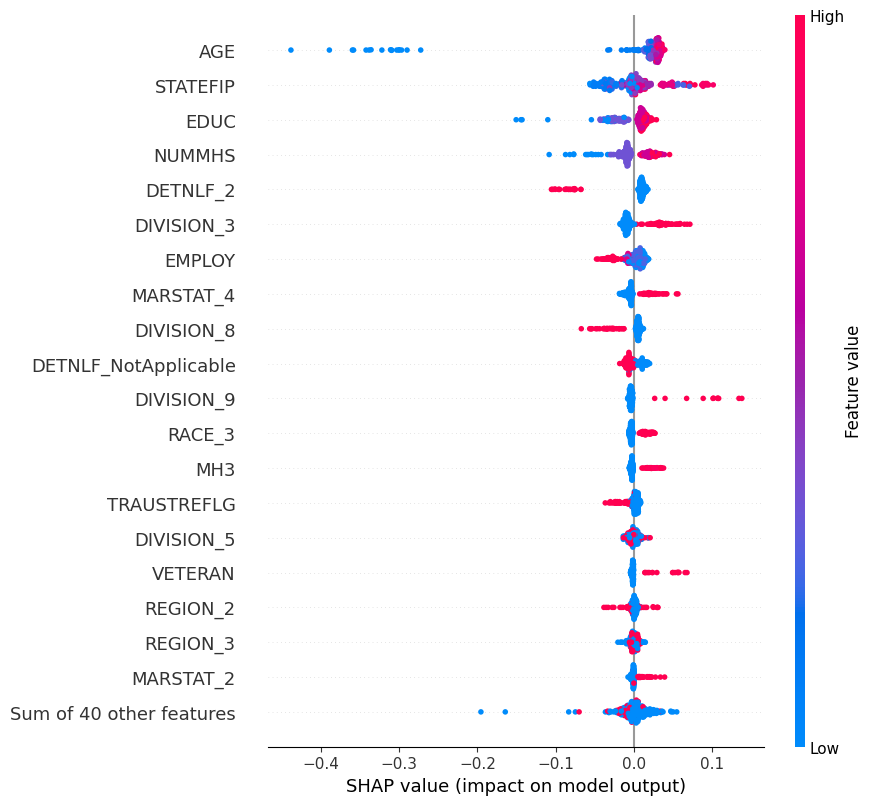

SMI


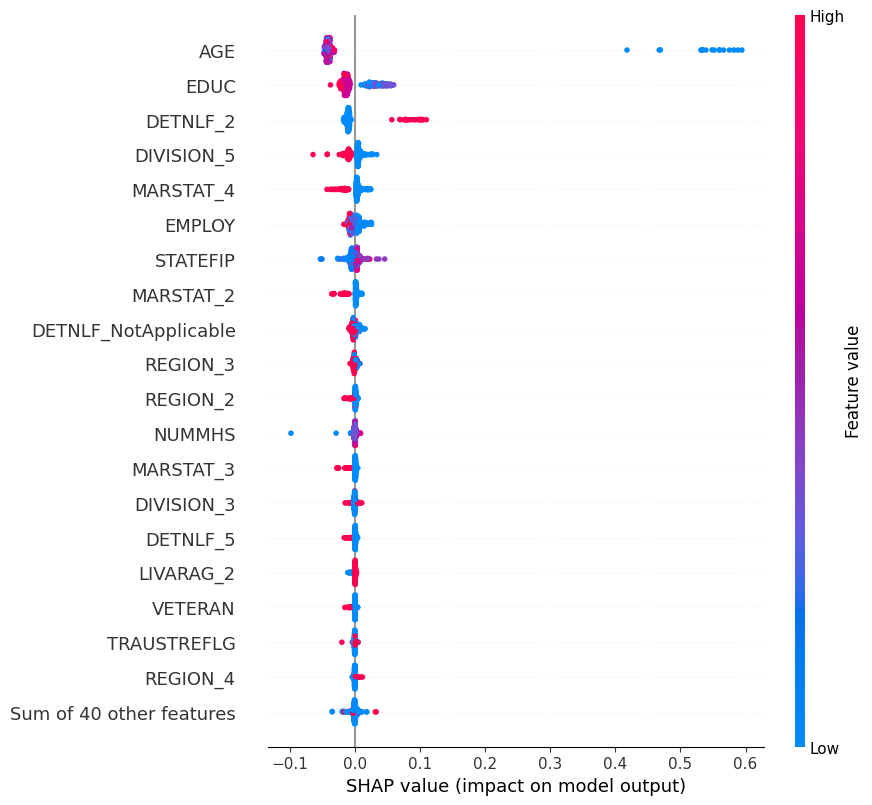

SED


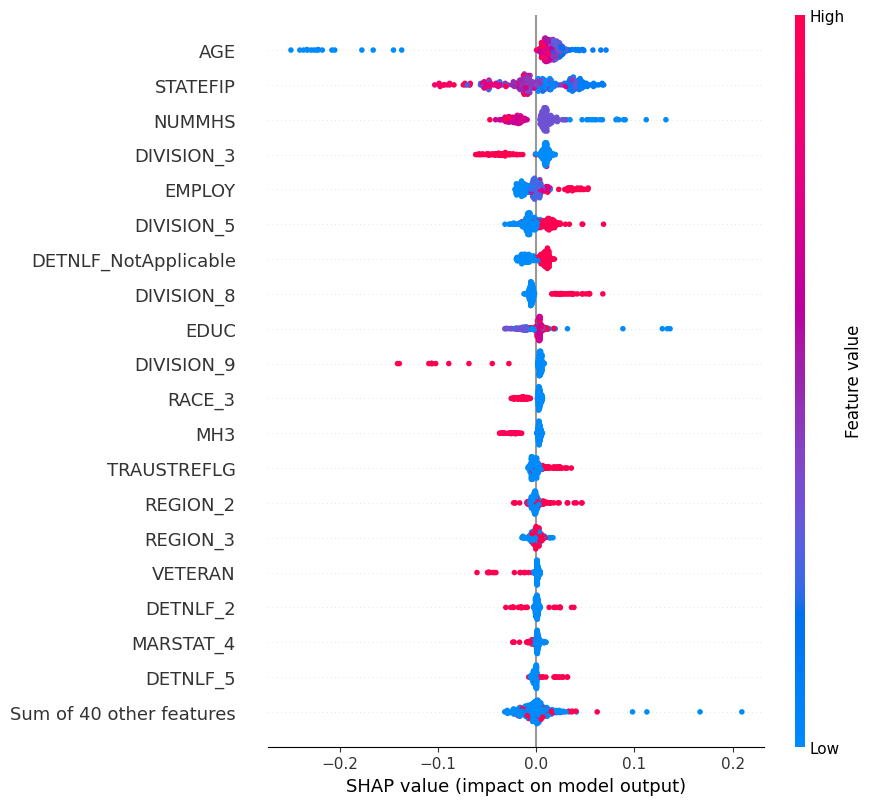

In [22]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# 진단 관련 변수 제거
diagnosis_vars = [
    'MH1', 'MH2', 'SAP',
    'SCHIZOFLG', 'BIPOLARFLG', 'DEPRESSFLG',
    'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG',
    'DELIRDEMFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG',
    'ALCSUBFLG', 'OTHERDISFLG'
]
df = df.drop(columns=diagnosis_vars, errors='ignore')

# X, y 재정의
y = df["SMISED"]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"], errors="ignore")

X = X.astype({col: int for col in X.select_dtypes('bool').columns})

X = X.drop(columns=X.select_dtypes('object').columns)

X = X.astype(float)


# 랜덤포레스트
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
model.fit(X, y)

# 예측값 및 정확도
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.4f}")

# SHAP
X_sample = X.sample(n=300, random_state=42)
def predict_proba_fn(X_input):
    return model.predict_proba(X_input)
explainer = shap.Explainer(predict_proba_fn, X_sample)
shap_values = explainer(X_sample)
class_names = {0: "None", 1: "SMI", 2: "SED"}

# 시각화
for i in range(shap_values.values.shape[2]):
    print(f"{class_names.get(i, str(i))}")
    shap.plots.beeswarm(shap_values[:, :, i], max_display=20)

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred, target_names=["None", "SMI", "SED"]))

              precision    recall  f1-score   support

        None       0.88      0.74      0.80    838304
         SMI       0.65      1.00      0.79     35078
         SED       0.43      0.61      0.50    274399

    accuracy                           0.71   1147781
   macro avg       0.65      0.78      0.70   1147781
weighted avg       0.76      0.71      0.73   1147781



In [24]:
# 클래스0 해당없음 SHAP 값
shap_values_class1 = shap_values[:, :, 0].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

AGE                     0.042689
STATEFIP                0.023830
EDUC                    0.017138
NUMMHS                  0.016972
DETNLF_2                0.016687
DIVISION_3              0.015341
EMPLOY                  0.009929
MARSTAT_4               0.009473
DIVISION_8              0.008480
DETNLF_NotApplicable    0.007643
dtype: float64


In [25]:
# 클래스1 중증 정신질환(SMI) SHAP 값
shap_values_class1 = shap_values[:, :, 1].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

AGE                     0.069938
EDUC                    0.020995
DETNLF_2                0.017538
DIVISION_5              0.008748
MARSTAT_4               0.007597
EMPLOY                  0.006075
STATEFIP                0.006058
MARSTAT_2               0.004607
DETNLF_NotApplicable    0.003246
REGION_3                0.002014
dtype: float64


In [26]:
# 클래스2 심각한 정서장애(SED) SHAP 값
shap_values_class1 = shap_values[:, :, 2].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

AGE                     0.028022
STATEFIP                0.027723
NUMMHS                  0.018307
DIVISION_3              0.015698
EMPLOY                  0.011670
DIVISION_5              0.010494
DETNLF_NotApplicable    0.009815
DIVISION_8              0.008283
EDUC                    0.008091
DIVISION_9              0.007444
dtype: float64


### 클래스0 (정신장애 없음)



### 클래스 0
AGE, NUMMHS, DETNLF_2, EDUC, MARTAT_4

연령(많을수록), NUMMHS(적음), DETNLF_2(양호), EDUC(높음), MARSTAT_4(가족이 안정됨)

### 클래스1 (SMI)
AGE, DETNLF_2, EDUC, MARSTAT_4, MARSTAT_2

연령(낮음), EDUC(낮음), DETNLF_2(실업), MARSTAT - 가족이 불안정함

### 클래스 2 (SED)
NUMMHS, AGE, EMPLOY, DETNLF_NotApplicable, RACE_3

AGE(청소ㅕㄴ층), NUMMHS(서비스 다수 이용), EMPLOY(경제활동 미참여), DETNLF_(고용상태 불안정), RACE_3(인종)

### **지역변수도 함께 제거**

상위 5개만 가지고 확인 중인데, 모두 질환제거했을 때와 항목은 동일

In [27]:
region_vars = [
    'STATEFIP',
    'REGION_1', 'REGION_2', 'REGION_3', 'REGION_4',
    'DIVISION_1', 'DIVISION_2', 'DIVISION_3',
    'DIVISION_4', 'DIVISION_5', 'DIVISION_6',
    'DIVISION_7', 'DIVISION_8', 'DIVISION_9'
]

Accuracy: 0.6800


PermutationExplainer explainer: 301it [01:56,  2.35it/s]


None


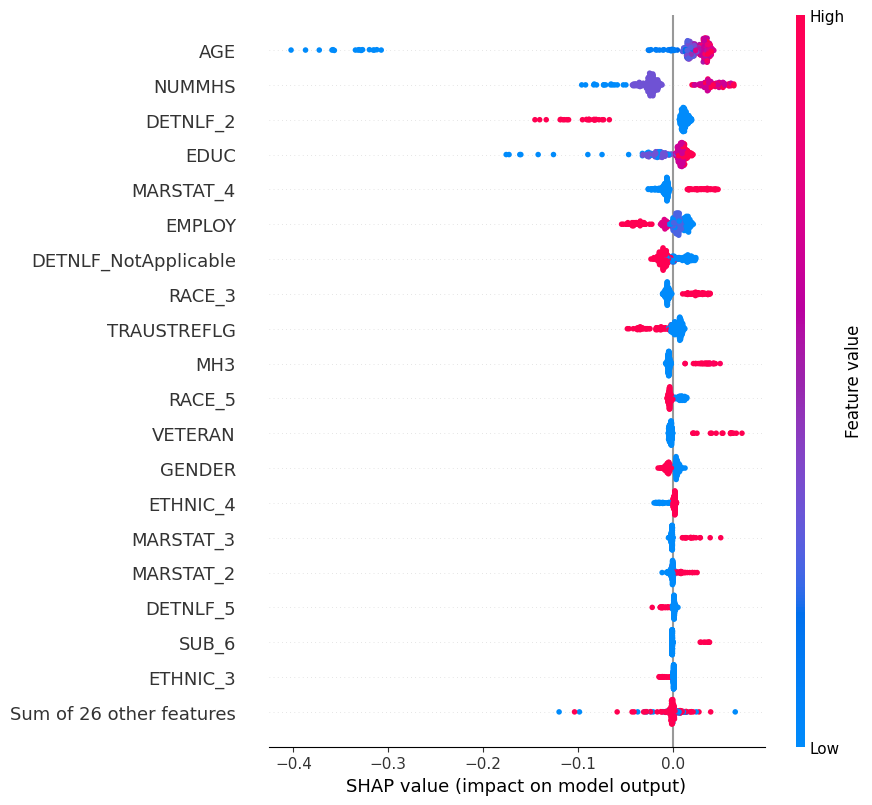

SMI


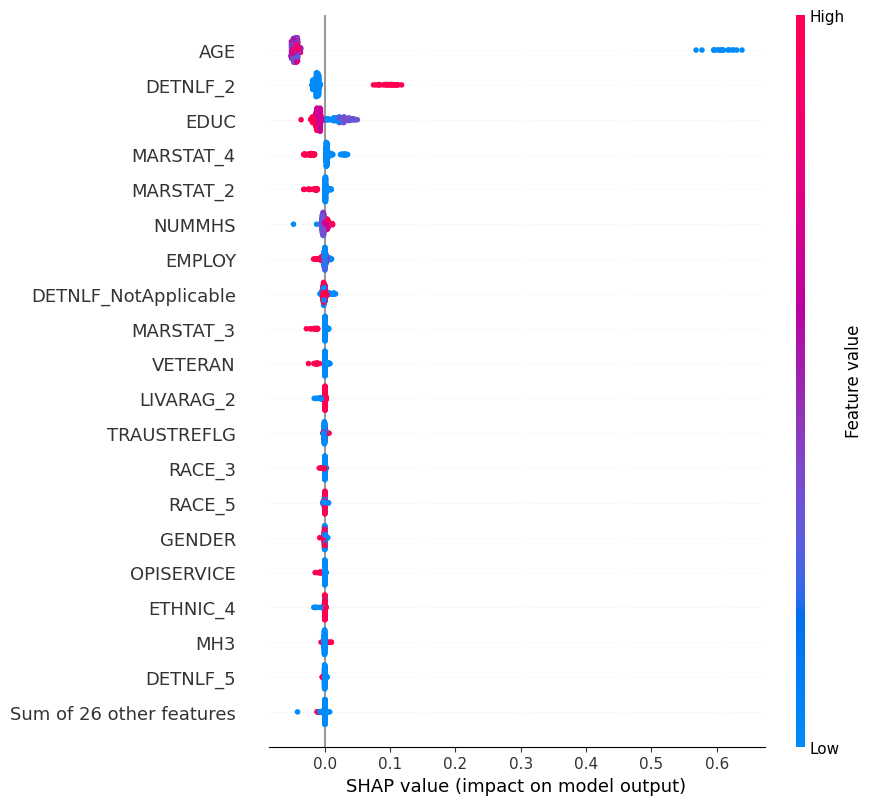

SED


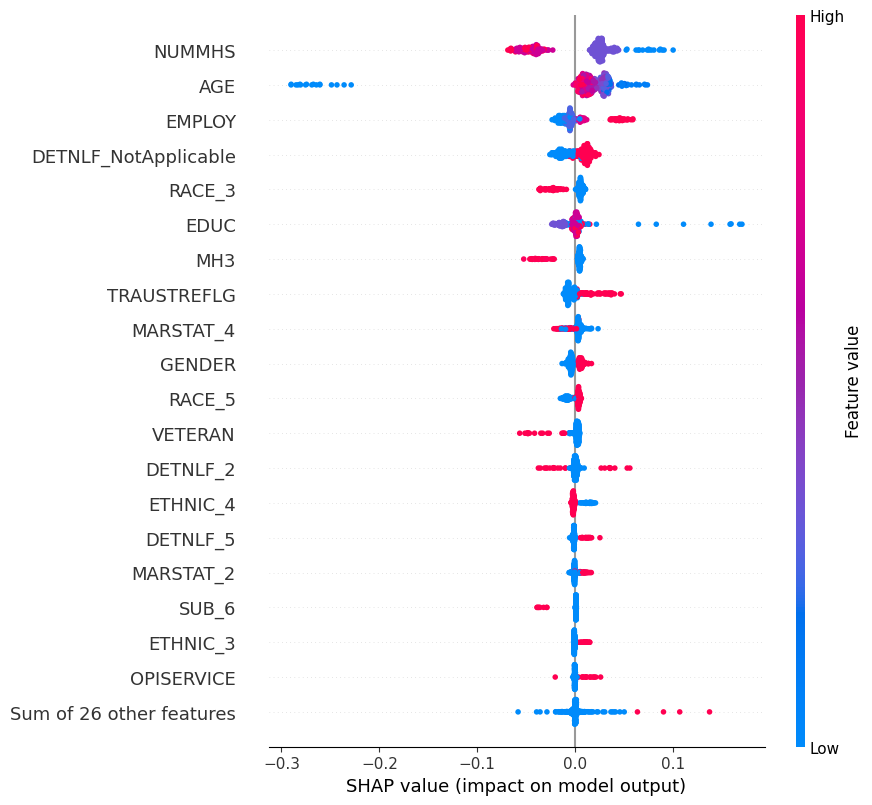

In [28]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# 지역 변수도 추가로 제거
region_vars = [
    'STATEFIP',
    'REGION_1', 'REGION_2', 'REGION_3', 'REGION_4',
    'DIVISION_1', 'DIVISION_2', 'DIVISION_3',
    'DIVISION_4', 'DIVISION_5', 'DIVISION_6',
    'DIVISION_7', 'DIVISION_8', 'DIVISION_9'
]

drop_vars = diagnosis_vars + region_vars
df = df.drop(columns=drop_vars, errors='ignore')

# 지역 변수 제거 이후 X, y 재정의
y = df["SMISED"]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"], errors="ignore")

X = X.astype({col: int for col in X.select_dtypes('bool').columns})

X = X.drop(columns=X.select_dtypes('object').columns)

X = X.astype(float)
# 랜덤포레스트
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
model.fit(X, y)

# 예측값 및 정확도
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.4f}")

# 11. SHAP
X_sample = X.sample(n=300, random_state=42)
def predict_proba_fn(X_input):
    return model.predict_proba(X_input)
explainer = shap.Explainer(predict_proba_fn, X_sample)
shap_values = explainer(X_sample)
class_names = {0: "None", 1: "SMI", 2: "SED"}

# 14. 시각화
for i in range(shap_values.values.shape[2]):
    print(f"{class_names.get(i, str(i))}")
    shap.plots.beeswarm(shap_values[:, :, i], max_display=20)

In [29]:
# 클래스0 해당없음 SHAP 값
shap_values_class1 = shap_values[:, :, 0].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

AGE                     0.044030
NUMMHS                  0.032840
DETNLF_2                0.019190
EDUC                    0.015472
MARSTAT_4               0.012652
EMPLOY                  0.012400
DETNLF_NotApplicable    0.010851
RACE_3                  0.010541
TRAUSTREFLG             0.008455
MH3                     0.007880
dtype: float64


In [30]:
# 클래스1 중증 정신질환(SMI) SHAP 값
shap_values_class1 = shap_values[:, :, 1].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

AGE                     0.077998
DETNLF_2                0.019397
EDUC                    0.015750
MARSTAT_4               0.008432
MARSTAT_2               0.003949
NUMMHS                  0.003224
EMPLOY                  0.002407
DETNLF_NotApplicable    0.002200
MARSTAT_3               0.002001
VETERAN                 0.001348
dtype: float64


In [31]:
# 클래스2 심각한 정서장애(SED) SHAP 값
shap_values_class1 = shap_values[:, :, 2].values
df3 = pd.DataFrame(shap_values_class1, columns=X_sample.columns)
importance = df3.abs().mean().sort_values(ascending=False)
print(importance.head(10))

NUMMHS                  0.035977
AGE                     0.035046
EMPLOY                  0.013754
DETNLF_NotApplicable    0.011298
RACE_3                  0.009880
EDUC                    0.008743
MH3                     0.008198
TRAUSTREFLG             0.008073
MARSTAT_4               0.005357
GENDER                  0.005212
dtype: float64


### **클래스 0 (해당 없음)**
**AGE, NUMMHS, DETNLF_2, EDUC, MARTAT_4**

연령(많을수록), NUMMHS(적음), DETNLF_2(양호), EDUC(높음), MARSTAT_4(가족이 안정됨)

---

### **클래스1 (SMI)**
**AGE, DETNLF_2, EDUC, MARSTAT_4, MARSTAT_2**

연령(낮음), EDUC(낮음), DETNLF_2(실업), MARSTAT - 가족이 불안정함

---

### **클래스 2 (SED)**
**NUMMHS, AGE, EMPLOY, DETNLF_NotApplicable, RACE_3**

AGE(청소년층), NUMMHS(서비스 다수 이용), EMPLOY(경제활동 미참여), DETNLF_(고용상태 불안정), RACE_3(인종)

### **XGBOOST : 모든 변수 포함**


랜덤포레스트와의 정확도 비교 위하여 XGBOOST행

In [33]:
from google.colab import drive
import pandas as pd
import shap
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# 데이터 다시 불러오기
file_path = '/content/drive/MyDrive/원핫인코딩_결측치가 포함된 모든 행 제거.csv'
df = pd.read_csv(file_path)

# 데이터 처리
df["SMISED"] = df[["SMISED_2", "SMISED_3"]].apply(
    lambda row: 1 if row["SMISED_2"] == 1 else (2 if row["SMISED_3"] == 1 else 0),
    axis=1
)
y = df["SMISED"]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"], errors="ignore")

X = X.astype(float)

# XGBoost
model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss",
    tree_method="hist"
)
model.fit(X, y)

# 예측 및 정확도
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.4f}")




/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:30:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8494


In [ ]:
print(type(shap_values))
print(len(shap_values))           # 클래스 개수?
print(shap_values[0].shape)       # 클래스 0에 대한 SHAP 값 shape
print(X_sample.shape)             # 피처 샘플 shape


In [ ]:
# SHAP
X_sample = X.sample(n=300, random_state=42)
X_sample = X_sample.loc[:, X.columns]

def predict_proba_fn(X_input):
    return model.predict_proba(X_input)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

#  시각화
class_names = {0: "None", 1: "SMI", 2: "SED"}
for i in range(3):  # 3 classes: 0=None, 1=SMI, 2=SED
    print(f"\n클래스 {i} ({class_names[i]})")

    shap_values_class_i = shap_values[:, :, i]

    shap.summary_plot(
        shap_values_class_i,
        features=X_sample,
        feature_names=X_sample.columns,
        plot_type="dot",
        max_display=20
    )


In [ ]:
print((X_sample.size))

In [ ]:
# 클래스0 해당없음 SHAP 값
importance = pd.DataFrame(shap_values[:,:,0], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)


In [ ]:
# 클래스1 중증 정신질환(SMI) SHAP 값
importance = pd.DataFrame(shap_values[:,:,1], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)

In [ ]:
# 클래스2 심각한 정서장애(SED) SHAP 값
importance = pd.DataFrame(shap_values[:,:,2], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)

### 진단 미포함

In [ ]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# 진단 관련 변수 제거
diagnosis_vars = [
    'MH1', 'MH2', 'SAP',
    'SCHIZOFLG', 'BIPOLARFLG', 'DEPRESSFLG',
    'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG',
    'DELIRDEMFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG',
    'ALCSUBFLG', 'OTHERDISFLG'
]
df = df.drop(columns=diagnosis_vars, errors='ignore')

# X, y 재정의
y = df["SMISED"]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"], errors="ignore")
X = X.astype({col: int for col in X.select_dtypes('bool').columns})
X = X.drop(columns=X.select_dtypes('object').columns)
X = X.astype(float)

# XGBoost
model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss",
    tree_method="hist"
)
model.fit(X, y)

# 예측 및 정확도
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.4f}")



In [ ]:
# SHAP
X_sample = X.sample(n=300, random_state=42)
X_sample = X_sample.loc[:, X.columns]

def predict_proba_fn(X_input):
    return model.predict_proba(X_input)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

print(type(shap_values))
print(len(shap_values))
print(shap_values[0].shape)
print(X_sample.shape)

#  시각화
class_names = {0: "None", 1: "SMI", 2: "SED"}
for i in range(3):  #
    print(f"\n클래스 {i} ({class_names[i]})")

    shap_values_class_i = shap_values[:, :, i]
    shap.summary_plot(
        shap_values_class_i,
        features=X_sample,
        feature_names=X_sample.columns,
        plot_type="dot",
        max_display=20
    )


In [ ]:
# 클래스0 해당없음 SHAP 값
importance = pd.DataFrame(shap_values[:,:,0], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 0], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["AGE"], shap_df["AGE"], alpha=0.3)
plt.xlabel("AGE")
plt.ylabel("SHAP value for AGE (GROUP0)")
plt.title("AGE vs SHAP value for GROUP0")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 0], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["NUMMHS"], shap_df["NUMMHS"], alpha=0.3)
plt.xlabel("NUMMHS")
plt.ylabel("SHAP value for NUMMHS(GROUP0)")
plt.title("NUMMHSvs SHAP value for GROUP0")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 0], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["STATEFIP"], shap_df["STATEFIP"], alpha=0.3)
plt.xlabel("STATEFIP")
plt.ylabel("SHAP value for STATEFIP (Class 2)")
plt.title("STATEFIP vs SHAP value for SED")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


In [ ]:
# 클래스1 중증 정신질환(SMI) SHAP 값
importance = pd.DataFrame(shap_values[:,:,1], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["AGE"], shap_df["AGE"], alpha=0.3)
plt.xlabel("AGE")
plt.ylabel("SHAP value for AGE (Class 1)")
plt.title("AGE vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["DETNLF_2"], shap_df["DETNLF_2"], alpha=0.3)
plt.xlabel("DETNLF_2")
plt.ylabel("SHAP value for DETNLF_2 (Class 1)")
plt.title("DETNLF_2 vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()

In [ ]:
# 클래스2 심각한 정서장애(SED) SHAP 값
importance = pd.DataFrame(shap_values[:,:,2], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["AGE"], shap_df["AGE"], alpha=0.3)
plt.xlabel("AGE")
plt.ylabel("SHAP value for AGE (Class 1)")
plt.title("AGE vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["STATEFIP"], shap_df["STATEFIP"], alpha=0.3)
plt.xlabel("STATEFIP")
plt.ylabel("SHAP value for STATEFIP (Class 2)")
plt.title("STATEFIP vs SHAP value for SED")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


### 진단+지역변수 미포함

In [34]:
region_vars = [
    'STATEFIP',
    'REGION_1', 'REGION_2', 'REGION_3', 'REGION_4',
    'DIVISION_1', 'DIVISION_2', 'DIVISION_3',
    'DIVISION_4', 'DIVISION_5', 'DIVISION_6',
    'DIVISION_7', 'DIVISION_8', 'DIVISION_9'
]

In [35]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# 진단 관련 변수 제거
diagnosis_vars = [
    'MH1', 'MH2', 'SAP',
    'SCHIZOFLG', 'BIPOLARFLG', 'DEPRESSFLG',
    'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG',
    'DELIRDEMFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG',
    'ALCSUBFLG', 'OTHERDISFLG'
]

drop_vars = diagnosis_vars + region_vars
df = df.drop(columns=drop_vars, errors='ignore')

# X, y 재정의
y = df["SMISED"]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"], errors="ignore")
X = X.astype({col: int for col in X.select_dtypes('bool').columns})
X = X.drop(columns=X.select_dtypes('object').columns)
X = X.astype(float)

# XGBoost
model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss",
    tree_method="hist"
)
model.fit(X, y)

# 예측 및 정확도
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.4f}")



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:33:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7803


<class 'numpy.ndarray'>
300
(45, 3)
(300, 45)

클래스 0 (None)


/tmp/ipython-input-36-2351853891.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


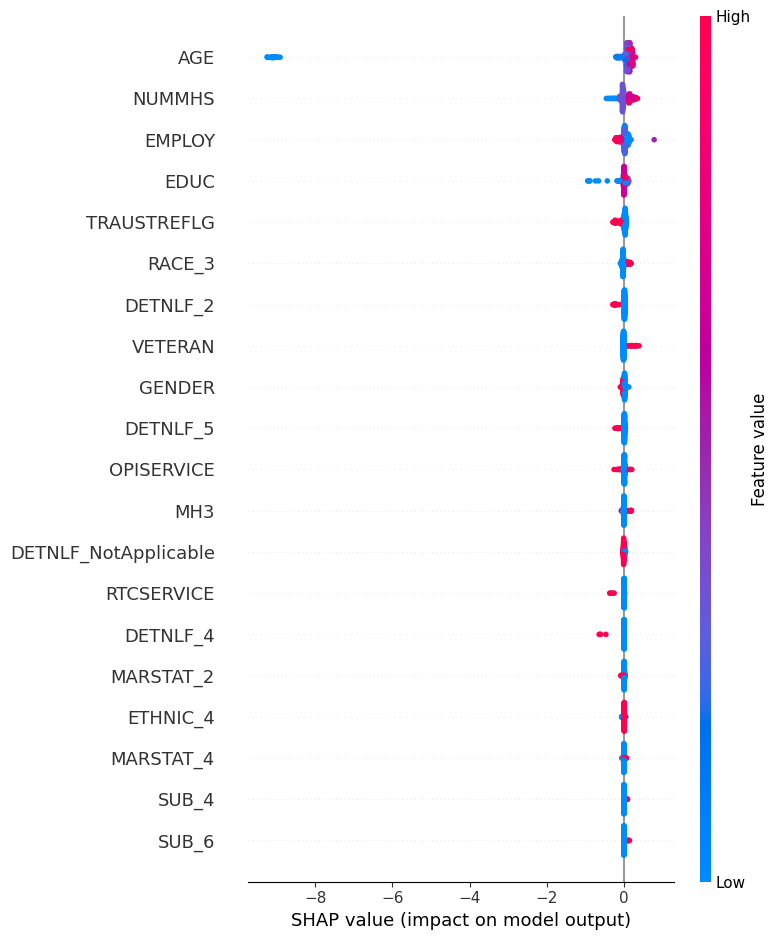


클래스 1 (SMI)


/tmp/ipython-input-36-2351853891.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


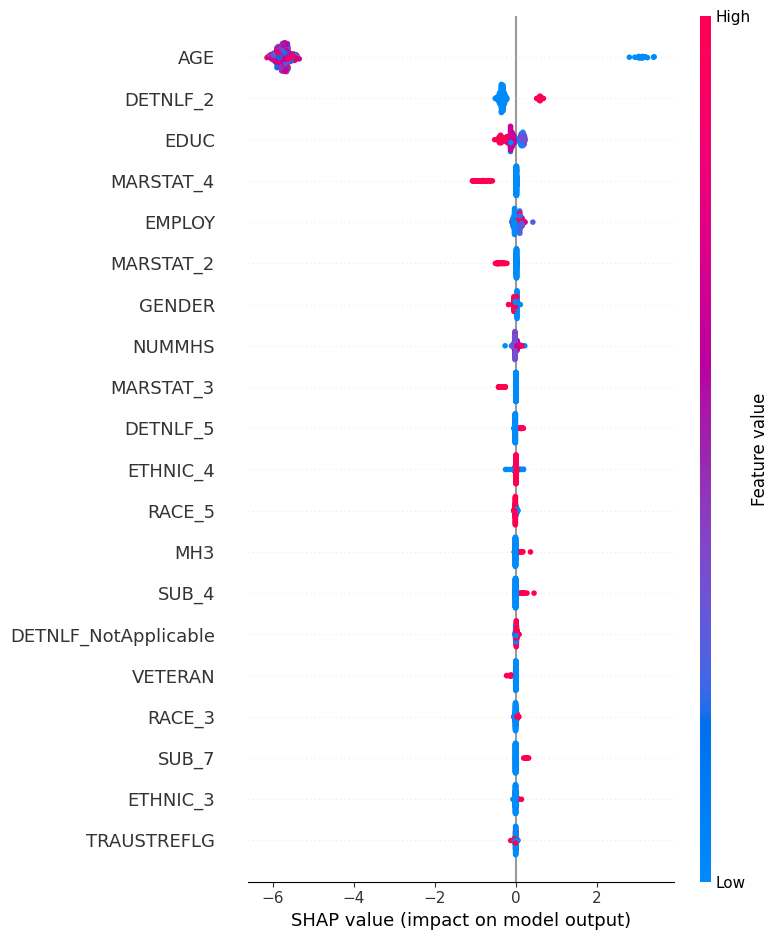


클래스 2 (SED)


/tmp/ipython-input-36-2351853891.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


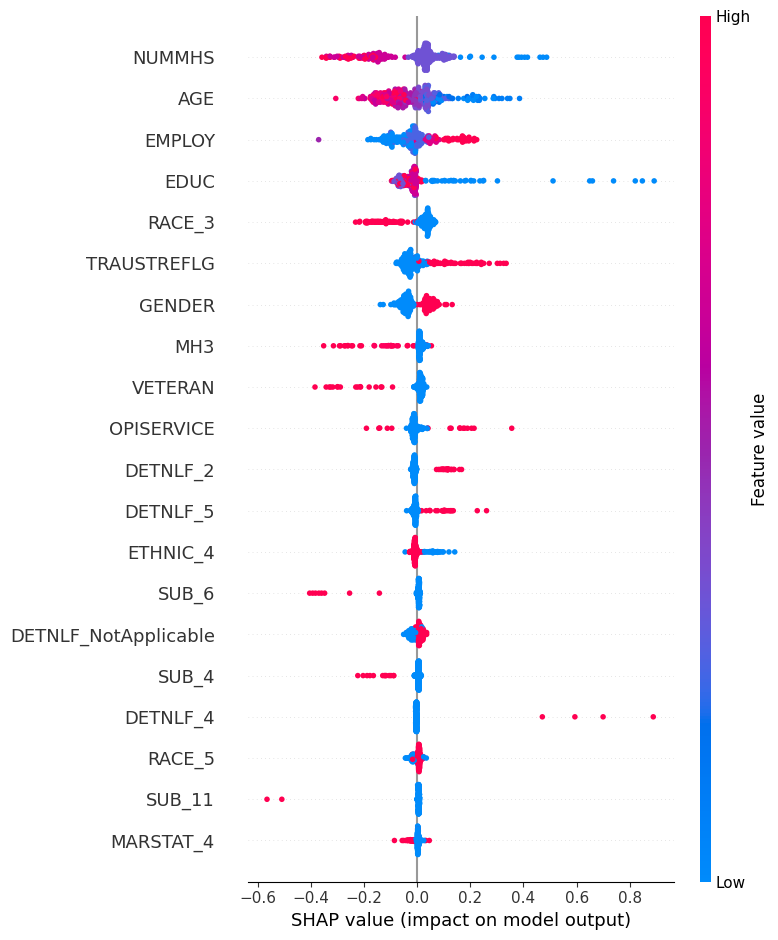

In [36]:
# SHAP
X_sample = X.sample(n=300, random_state=42)
X_sample = X_sample.loc[:, X.columns]

def predict_proba_fn(X_input):
    return model.predict_proba(X_input)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

print(type(shap_values))
print(len(shap_values))
print(shap_values[0].shape)
print(X_sample.shape)

#  시각화
class_names = {0: "None", 1: "SMI", 2: "SED"}
for i in range(3):  #
    print(f"\n클래스 {i} ({class_names[i]})")

    shap_values_class_i = shap_values[:, :, i]
    shap.summary_plot(
        shap_values_class_i,
        features=X_sample,
        feature_names=X_sample.columns,
        plot_type="dot",
        max_display=20
    )


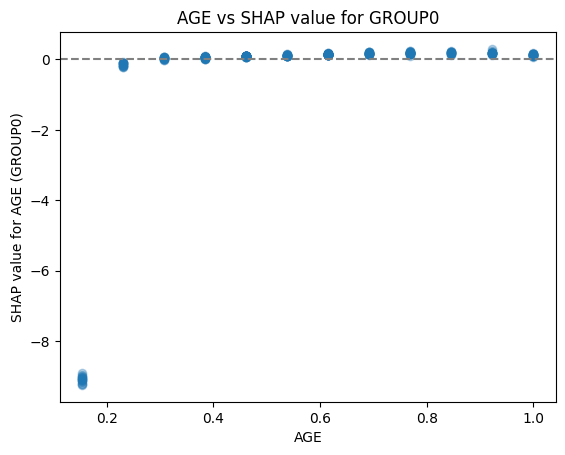

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 0], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["AGE"], shap_df["AGE"], alpha=0.3)
plt.xlabel("AGE")
plt.ylabel("SHAP value for AGE (GROUP0)")
plt.title("AGE vs SHAP value for GROUP0")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


### AGE까지 제거 (최종 선택본 )###

In [53]:
from google.colab import drive
import pandas as pd
import shap
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# 데이터 다시 불러오기
file_path = '/content/drive/MyDrive/원핫인코딩_결측치가 포함된 모든 행 제거.csv'
df = pd.read_csv(file_path)


# 진단 관련 변수 제거+AGE
diagnosis_vars = [
    'MH1', 'MH2', 'SAP',
    'SCHIZOFLG', 'BIPOLARFLG', 'DEPRESSFLG',
    'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG',
    'DELIRDEMFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG',
    'ALCSUBFLG', 'OTHERDISFLG', 'AGE'
]

drop_vars = diagnosis_vars + region_vars
df = df.drop(columns=drop_vars, errors='ignore')

# 데이터 처리
df["SMISED"] = df[["SMISED_2", "SMISED_3"]].apply(
    lambda row: 1 if row["SMISED_2"] == 1 else (2 if row["SMISED_3"] == 1 else 0),
    axis=1
)
y = df["SMISED"]
X = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"], errors="ignore")

X = X.astype(float)

# XGBoost
model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss",
    tree_method="hist"
)
model.fit(X, y)

# 예측 및 정확도
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:50:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7607


<class 'numpy.ndarray'>
300
(44, 3)
(300, 44)

클래스 0 (None)


/tmp/ipython-input-54-2351853891.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


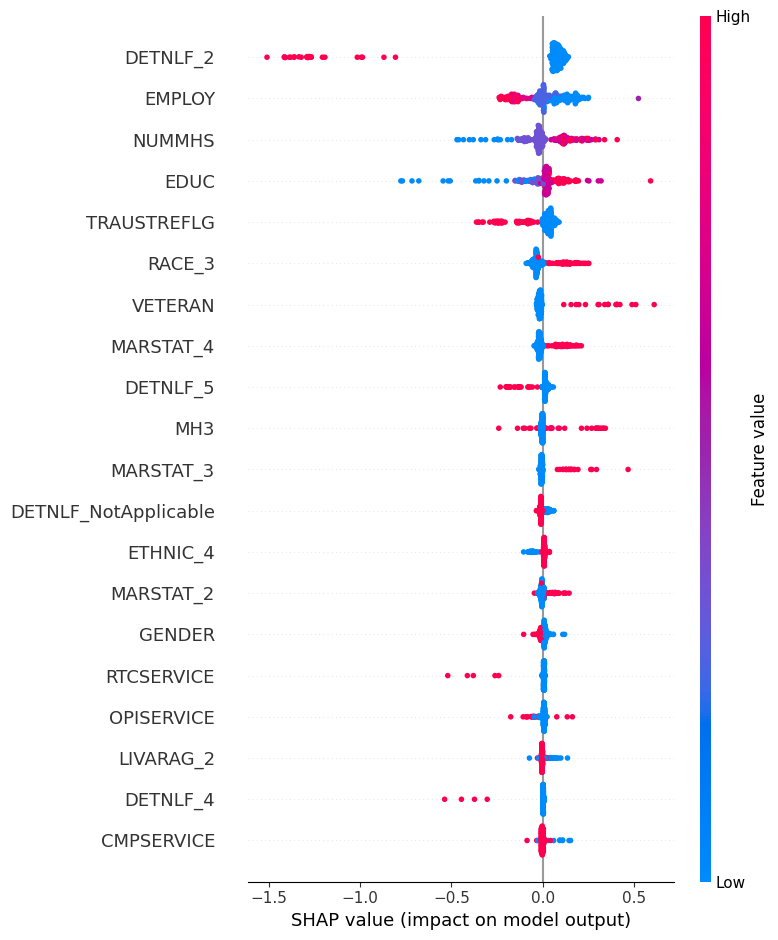


클래스 1 (SMI)


/tmp/ipython-input-54-2351853891.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


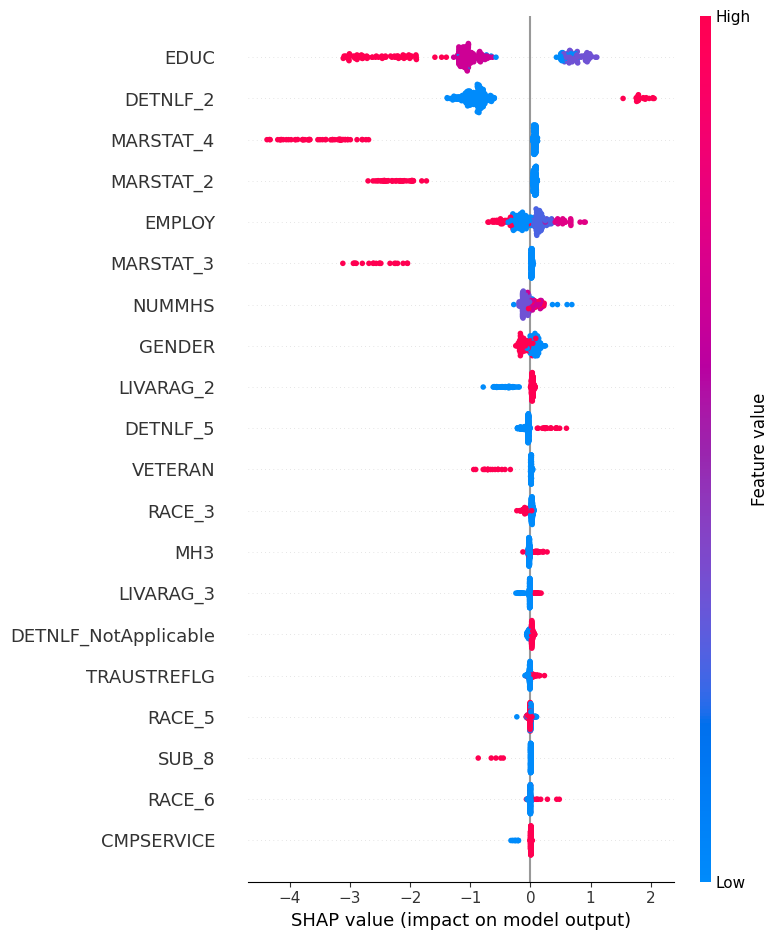


클래스 2 (SED)


/tmp/ipython-input-54-2351853891.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


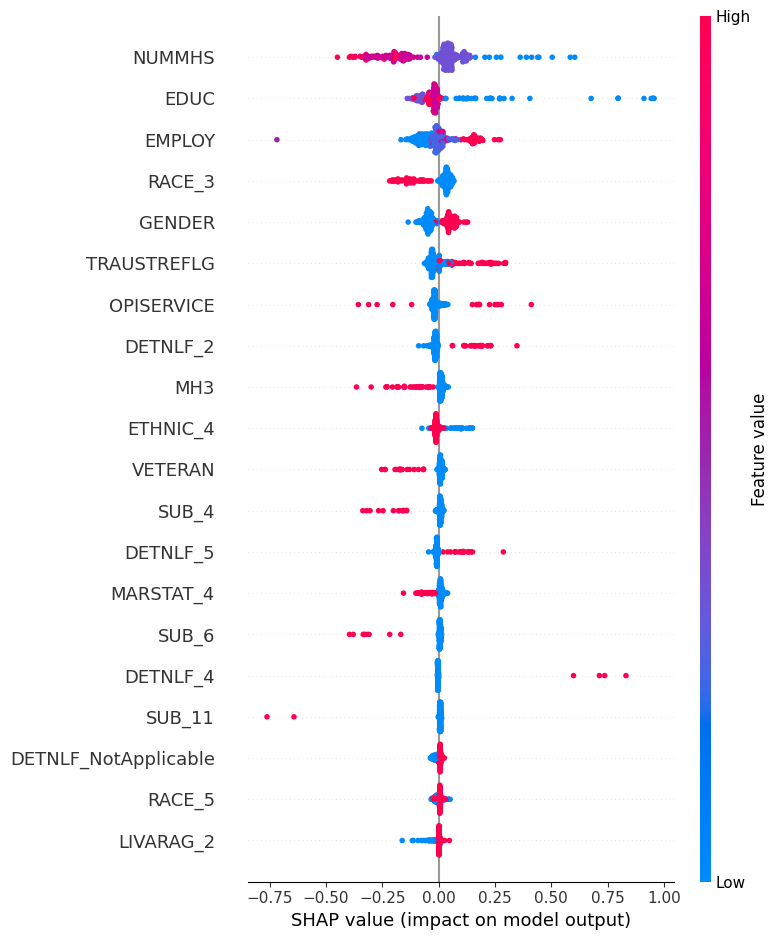

In [54]:
# SHAP
X_sample = X.sample(n=300, random_state=42)
X_sample = X_sample.loc[:, X.columns]

def predict_proba_fn(X_input):
    return model.predict_proba(X_input)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

print(type(shap_values))
print(len(shap_values))
print(shap_values[0].shape)
print(X_sample.shape)

#  시각화
class_names = {0: "None", 1: "SMI", 2: "SED"}
for i in range(3):  #
    print(f"\n클래스 {i} ({class_names[i]})")

    shap_values_class_i = shap_values[:, :, i]
    shap.summary_plot(
        shap_values_class_i,
        features=X_sample,
        feature_names=X_sample.columns,
        plot_type="dot",
        max_display=20
    )


In [55]:
# 클래스0 해당없음 SHAP 값
importance = pd.DataFrame(shap_values[:,:,0], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)


DETNLF_2       0.177375
EMPLOY         0.096932
NUMMHS         0.088775
EDUC           0.073656
TRAUSTREFLG    0.061876
RACE_3         0.055875
VETERAN        0.036301
MARSTAT_4      0.034670
DETNLF_5       0.026276
MH3            0.021003
dtype: float32


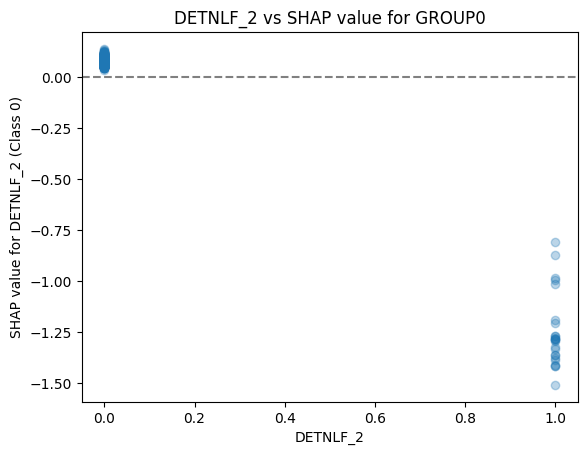

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 0], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["DETNLF_2"], shap_df["DETNLF_2"], alpha=0.3)
plt.xlabel("DETNLF_2")
plt.ylabel("SHAP value for DETNLF_2 (Class 0)")
plt.title("DETNLF_2 vs SHAP value for GROUP0")
plt.axhline(0, color='gray', linestyle='--')
plt.show()

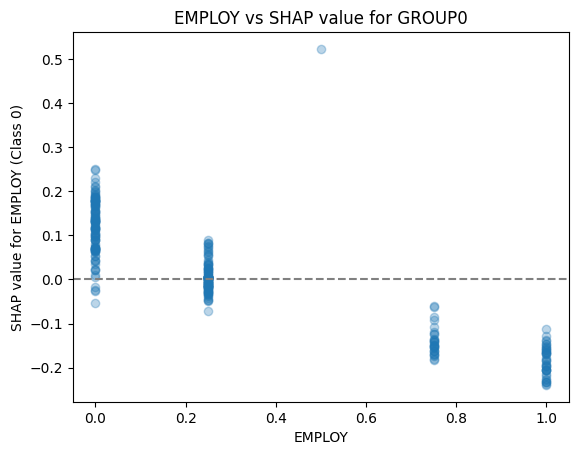

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 0], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["EMPLOY"], shap_df["EMPLOY"], alpha=0.3)
plt.xlabel("EMPLOY")
plt.ylabel("SHAP value for EMPLOY (Class 0)")
plt.title("EMPLOY vs SHAP value for GROUP0")
plt.axhline(0, color='gray', linestyle='--')
plt.show()

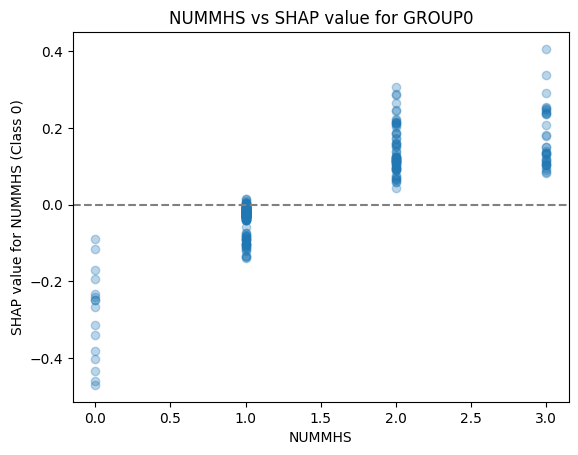

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 0], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["NUMMHS"], shap_df["NUMMHS"], alpha=0.3)
plt.xlabel("NUMMHS")
plt.ylabel("SHAP value for NUMMHS (Class 0)")
plt.title("NUMMHS vs SHAP value for GROUP0")
plt.axhline(0, color='gray', linestyle='--')
plt.show()

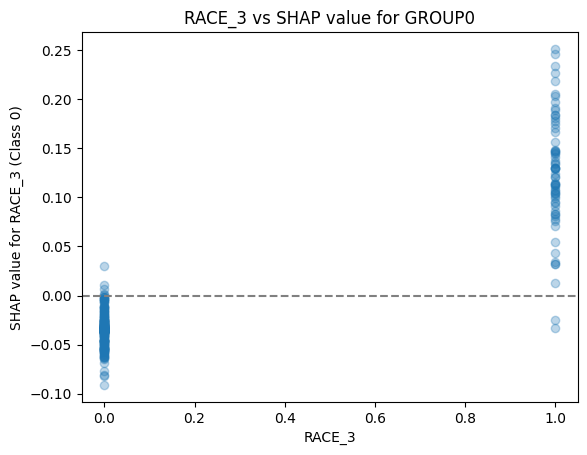

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 0], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["RACE_3"], shap_df["RACE_3"], alpha=0.3)
plt.xlabel("RACE_3")
plt.ylabel("SHAP value for RACE_3 (Class 0)")
plt.title("RACE_3 vs SHAP value for GROUP0")
plt.axhline(0, color='gray', linestyle='--')
plt.show()

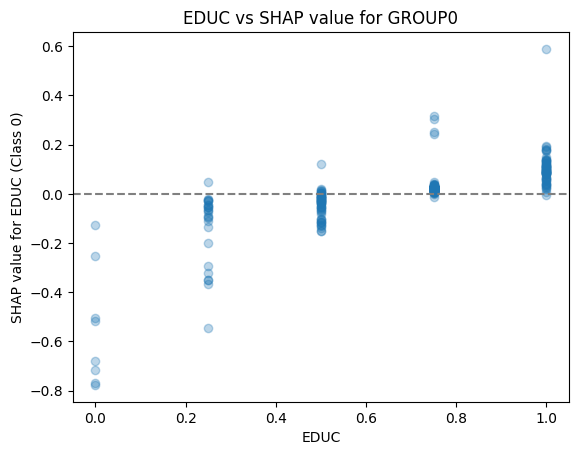

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 0], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["EDUC"], shap_df["EDUC"], alpha=0.3)
plt.xlabel("EDUC")
plt.ylabel("SHAP value for EDUC (Class 0)")
plt.title("EDUC vs SHAP value for GROUP0")
plt.axhline(0, color='gray', linestyle='--')
plt.show()

In [57]:
# 클래스1 중증 정신질환(SMI) SHAP 값
importance = pd.DataFrame(shap_values[:,:,1], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)


EDUC         1.279849
DETNLF_2     1.001017
MARSTAT_4    0.669768
MARSTAT_2    0.374340
EMPLOY       0.234723
MARSTAT_3    0.188497
NUMMHS       0.097406
GENDER       0.093621
LIVARAG_2    0.088724
DETNLF_5     0.079313
dtype: float32


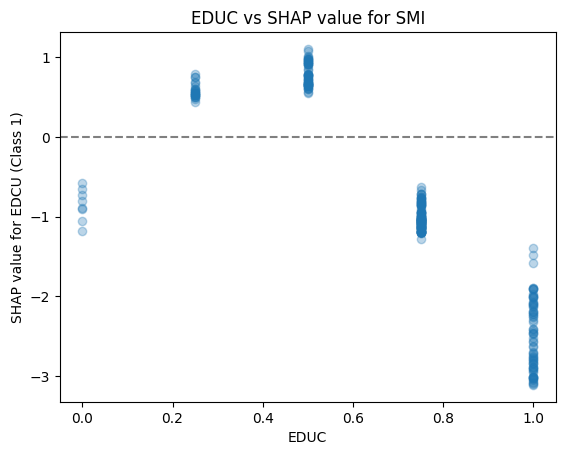

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["EDUC"], shap_df["EDUC"], alpha=0.3)
plt.xlabel("EDUC")
plt.ylabel("SHAP value for EDCU (Class 1)")
plt.title("EDUC vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


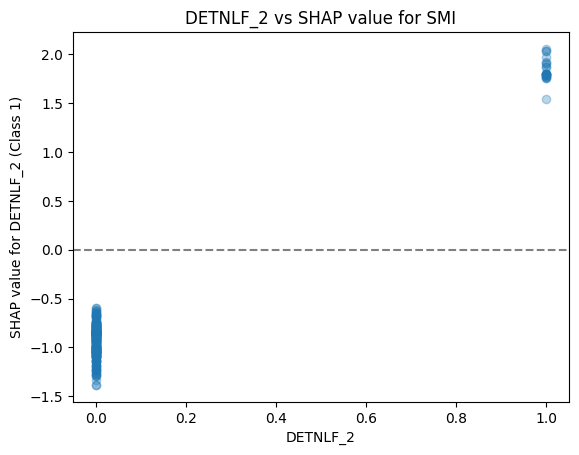

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["DETNLF_2"], shap_df["DETNLF_2"], alpha=0.3)
plt.xlabel("DETNLF_2")
plt.ylabel("SHAP value for DETNLF_2 (Class 1)")
plt.title("DETNLF_2 vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


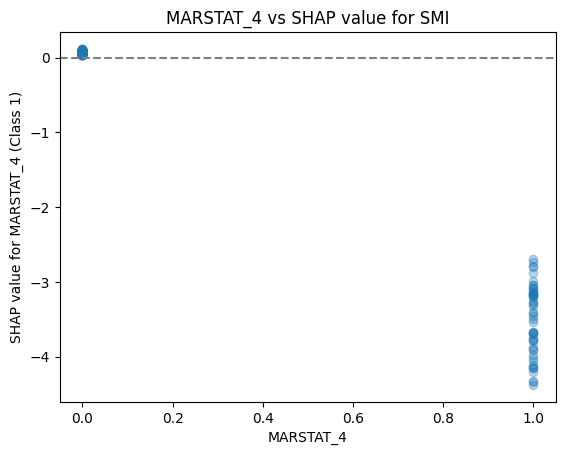

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["MARSTAT_4"], shap_df["MARSTAT_4"], alpha=0.3)
plt.xlabel("MARSTAT_4")
plt.ylabel("SHAP value for MARSTAT_4 (Class 1)")
plt.title("MARSTAT_4 vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


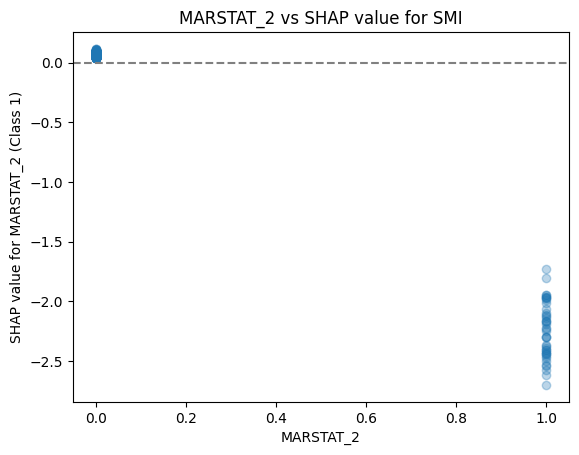

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["MARSTAT_2"], shap_df["MARSTAT_2"], alpha=0.3)
plt.xlabel("MARSTAT_2")
plt.ylabel("SHAP value for MARSTAT_2 (Class 1)")
plt.title("MARSTAT_2 vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


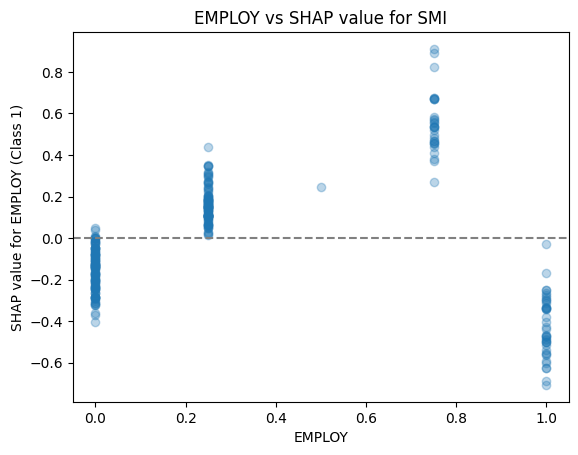

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["EMPLOY"], shap_df["EMPLOY"], alpha=0.3)
plt.xlabel("EMPLOY")
plt.ylabel("SHAP value for EMPLOY (Class 1)")
plt.title("EMPLOY vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


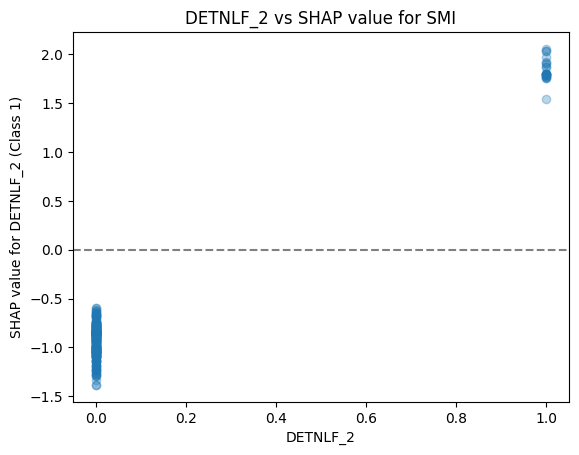

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 1], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["DETNLF_2"], shap_df["DETNLF_2"], alpha=0.3)
plt.xlabel("DETNLF_2")
plt.ylabel("SHAP value for DETNLF_2 (Class 1)")
plt.title("DETNLF_2 vs SHAP value for SMI")
plt.axhline(0, color='gray', linestyle='--')
plt.show()

In [59]:
# 클래스2 심각한 정서장애(SED) SHAP 값
importance = pd.DataFrame(shap_values[:,:,2], columns=X_sample.columns)
top10 = importance.abs().mean().sort_values(ascending=False).head(10)
print(top10)

NUMMHS         0.125303
EDUC           0.068592
EMPLOY         0.061402
RACE_3         0.056340
GENDER         0.049537
TRAUSTREFLG    0.048231
OPISERVICE     0.030482
DETNLF_2       0.028562
MH3            0.025552
ETHNIC_4       0.020582
dtype: float32


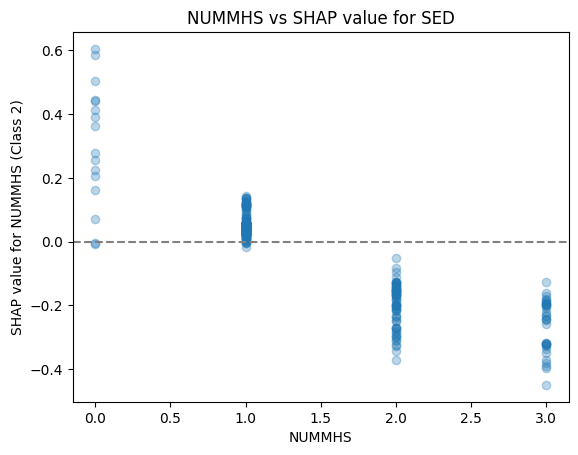

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 2], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["NUMMHS"], shap_df["NUMMHS"], alpha=0.3)
plt.xlabel("NUMMHS")
plt.ylabel("SHAP value for NUMMHS (Class 2)")
plt.title("NUMMHS vs SHAP value for SED")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


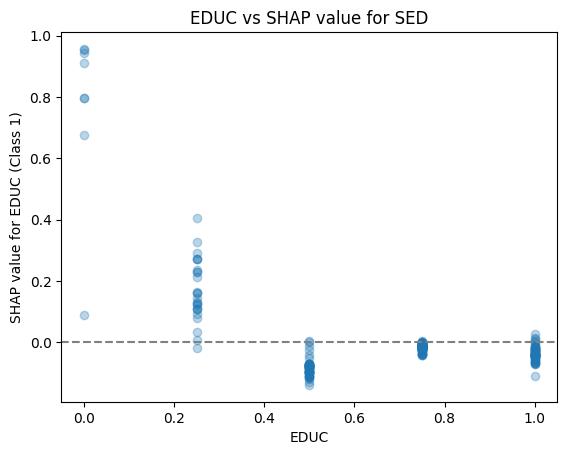

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 2], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["EDUC"], shap_df["EDUC"], alpha=0.3)
plt.xlabel("EDUC")
plt.ylabel("SHAP value for EDUC (Class 2)")
plt.title("EDUC vs SHAP value for SED")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


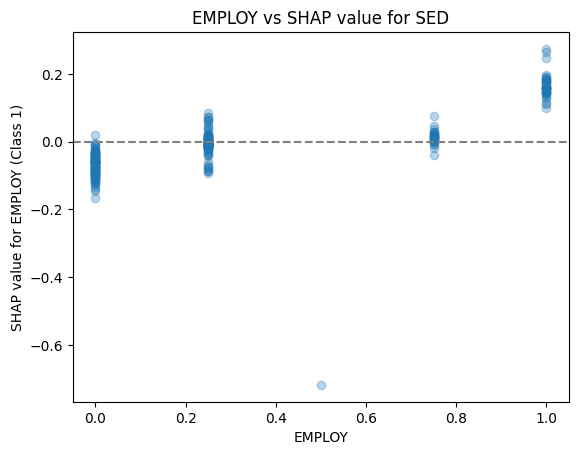

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 2], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["EMPLOY"], shap_df["EMPLOY"], alpha=0.3)
plt.xlabel("EMPLOY")
plt.ylabel("SHAP value for EMPLOY (Class 2)")
plt.title("EMPLOY vs SHAP value for SED")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


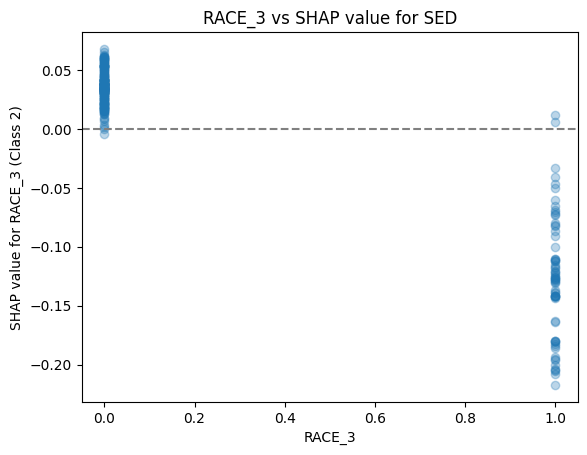

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 2], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["RACE_3"], shap_df["RACE_3"], alpha=0.3)
plt.xlabel("RACE_3")
plt.ylabel("SHAP value for RACE_3 (Class 2)")
plt.title("RACE_3 vs SHAP value for SED")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


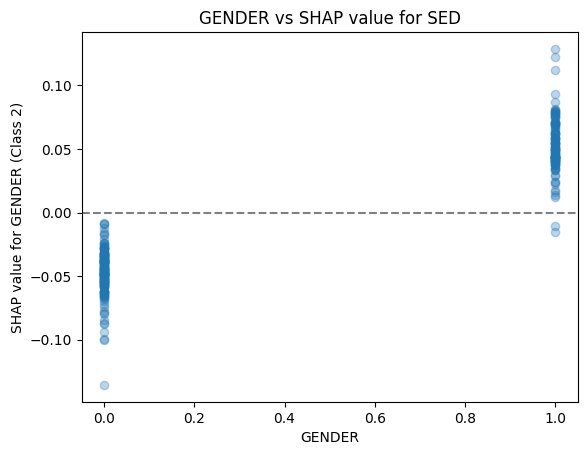

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

# SHAP 값 DataFrame
shap_df = pd.DataFrame(shap_values[:,:, 2], columns=X_sample.columns)

# 시각화
plt.scatter(X_sample["GENDER"], shap_df["GENDER"], alpha=0.3)
plt.xlabel("GENDER")
plt.ylabel("SHAP value for GENDER (Class 2)")
plt.title("GENDER vs SHAP value for SED")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


# **STEP4. 로지스틱 회귀분석**

In [62]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

df["SMISED"] = df[["SMISED_2", "SMISED_3"]].apply(
    lambda row: 1 if row["SMISED_2"] == 1 else (2 if row["SMISED_3"] == 1 else 0),
    axis=1
)
y = df["SMISED"]

diagnosis_vars = [
    'MH1', 'MH2', 'MH3', 'SAP',
    'SCHIZOFLG', 'BIPOLARFLG', 'DEPRESSFLG',
    'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG',
    'DELIRDEMFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG',
    'ALCSUBFLG', 'OTHERDISFLG', 'AGE'
]

region_vars = [
    'STATEFIP',
    'REGION_1', 'REGION_2', 'REGION_3', 'REGION_4',
    'DIVISION_1', 'DIVISION_2', 'DIVISION_3',
    'DIVISION_4', 'DIVISION_5', 'DIVISION_6',
    'DIVISION_7', 'DIVISION_8', 'DIVISION_9'
]


group0_vars = ['DETNLF_2', 'EMPLOY', 'NUMMHS', 'EDUC', 'TRAUSTREFLG']
group1_vars = ['EDUC', 'DETNLF_2', 'MARSTAT_4', 'MARSTAT_2', 'EMPLOY']
group2_vars = ['NUMMHS', 'EDUC', 'EMPLOY', 'RACE_3', 'GENDER']

X_base = df.drop(columns=["SMISED", "SMISED_2", "SMISED_3", "CASEID"] + diagnosis_vars+ region_vars, errors='ignore')


scaler = StandardScaler()

for grp, vars in zip(['GROUP0', 'GROUP1', 'GROUP2'],
                     [group0_vars, group1_vars, group2_vars]):

    print(f"\n===== {grp} One-vs-Rest Logistic =====")

    X = X_base[vars].copy()

    # 스케일링
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=vars)
    X_scaled = sm.add_constant(X_scaled)

    # 타겟: 현재 그룹 vs 나머지
    y_bin = (y == int(grp[-1])).astype(int)

    model = sm.Logit(y_bin, X_scaled)
    result = model.fit()

    print(result.summary())




===== GROUP0 One-vs-Rest Logistic =====
Optimization terminated successfully.
         Current function value: 0.531742
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 SMISED   No. Observations:              1147781
Model:                          Logit   Df Residuals:                  1147775
Method:                           MLE   Df Model:                            5
Date:                Fri, 20 Jun 2025   Pseudo R-squ.:                 0.08775
Time:                        02:09:34   Log-Likelihood:            -6.1032e+05
converged:                       True   LL-Null:                   -6.6903e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0773      0.002    472.965      0.000       1.0

# **STEP5. Clustering**

shap 결과 바탕으로 클러스터링을 준비하고 클러스터링 진행.

In [ ]:
print(X_sample.columns.tolist())
